In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score, Accuracy, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

In [19]:
df = pd.read_csv('./datasets/cumulative_2025.10.04_11.08.40.csv')
df.head()
# Dropping all the columns that are not needed
df = df.drop(columns=['rowid','kepid','kepoi_name','kepler_name'])

# Dropping empty columns
df = df.dropna(axis=1, how='all')

In [34]:
# Calculate the mutual information
from sklearn.feature_selection import mutual_info_regression
# Prepare raw data (before normalization) for mutual information calculation
X_raw = df.drop("koi_disposition", axis=1)
df_corr = df.drop(columns=["koi_pdisposition"])
df_corr["koi_disposition"] = df_corr["koi_disposition"].replace({"CONFIRMED": 2, "CANDIDATE": 1, "FALSE POSITIVE": 0})

# Select only numeric columns for correlation
numeric_df = df_corr.select_dtypes(include=[np.number])

# Drop rows with NaN values only in the columns needed for MI calculation
mi_features = numeric_df.drop("koi_disposition", axis=1)
mi_target = numeric_df["koi_disposition"]
mi_df = numeric_df.dropna(subset=mi_features.columns.tolist() + ["koi_disposition"])

# Calculate mutual information for all numeric features if there are samples
if len(mi_df) > 0:
	mi = mutual_info_regression(mi_df.drop("koi_disposition", axis=1), mi_df["koi_disposition"])
	mi_series = pd.Series(mi, index=mi_df.drop("koi_disposition", axis=1).columns)
	mi_series.sort_values(ascending=False)
else:
	print("No samples available for mutual information calculation after dropping NaNs.")
	
# Drops columns with mi value less than 0.1 in the original dataframe

mi_series = mi_series[mi_series > 0.1]
# Drops 'score' column
mi_series = mi_series.drop(labels=['koi_score'], errors='ignore')	
#  Plot mutual information as a bar chart using Plotly
import plotly.express as px 
mi_df_plot = mi_series.reset_index()
mi_df_plot.columns = ['Feature', 'Mutual Information']
fig = px.bar(mi_df_plot, x='Feature', y='Mutual Information', title='Mutual Information of Features with koi disposition', labels={'Mutual Information': 'Mutual Information', 'Feature': 'Features'})
fig.show()

# Features com MI >= 0.1
selected_features = mi_series.index.tolist()

# Inclui a coluna alvo de volta
selected_features.append("koi_disposition")

# Cria um novo dataframe só com as colunas relevantes
df_filtered = df_corr[selected_features]

C:\Users\gpgir\AppData\Local\Temp\ipykernel_27692\550124377.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



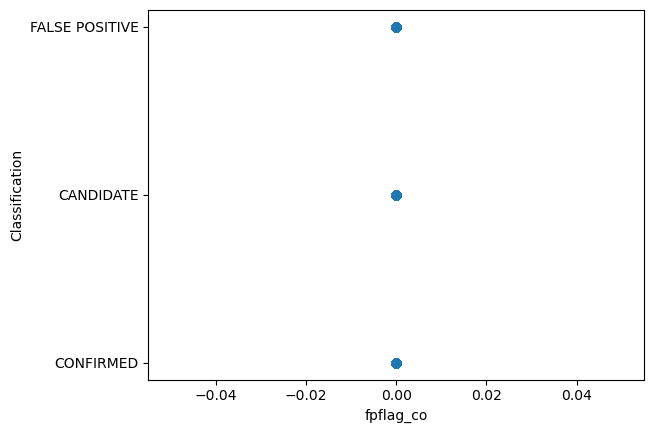

In [32]:
import matplotlib.pyplot as plt

plt.scatter(df["koi_eccen"], df["koi_disposition"], alpha=0.5)
plt.xlabel("fpflag_co")
plt.ylabel("Classification")
plt.show()

In [40]:
%pip install -q kaleido
import plotly.express as px
# Drop non-numeric columns except 'koi_disposition'
# df_corr = df.drop(columns=["koi_pdisposition"])
# df_corr["koi_disposition"] = df_corr["koi_disposition"].replace({"CONFIRMED": 2, "CANDIDATE": 1, "FALSE POSITIVE": 0})

# Select only numeric columns for correlation
numeric_df = df_filtered.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize with Plotly
fig = px.imshow(
    correlation_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='Matriz de Correlação (com outliers removidos)',
    labels=dict(x="Variáveis", y="Variáveis", color="Correlação")
)
fig.update_layout(
    width=1600,
    height=1600,
    xaxis_side="bottom"
)
# Downloads the image
fig.write_image("correlation_matrix_filtered.png", scale=2)
fig.show()

Note: you may need to restart the kernel to use updated packages.


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
